## classarchetypes.ipynb

In [1]:
import sys
sys.path.insert(0,'../cropseg/')

datasetinfo = { "datadir":"/home/ucfaab0/Desktop/su_african_crops_ghana/",
                "metadatadir":"/home/ucfaab0/Desktop/su_african_crops_ghana/metadata/",
                "dataset":"su_african_crops_ghana",
                "groundcollection":"su_african_crops_ghana_labels",
                "s1collection":"su_african_crops_ghana_source_s1",
                "s2collection":"su_african_crops_ghana_source_s2",
                "groundlabels":"su_african_crops_ghana_labels_id.json",
                "groundmetadata":"su_african_crops_ghana_labels.json",
                "s1metadata":"su_african_crops_ghana_source_s1.json",
                "s2metadata":"su_african_crops_ghana_source_s2.json",
                "groundname":"labels.tif",
                "s1imagename":"source.tif",
                "s2imagename":"source.tif",
                "s2maskname":"cloudmask.tif",
                "groundshape":[64,64],
                "s1shape":[64,64],
                "s2shape":[64,64],
                "extension":"tif"
              }
s1bands = [
            {"band":"vv","idx":0},
            {"band":"vh","idx":1},    
          ]  
s2bands = [
            {"band":"blue","wavelength":490,"idx":0},
            {"band":"green","wavelength":560,"idx":1},
            {"band":"red","wavelength":665,"idx":2},
            {"band":"rded1","wavelength":705,"idx":3},
            {"band":"rded2","wavelength":740,"idx":4},
            {"band":"rded3","wavelength":783,"idx":5},
            {"band":"nir","wavelength":842,"idx":6},
            {"band":"rded4","wavelength":865,"idx":7},
            {"band":"swir1","wavelength":1610,"idx":8},
            {"band":"swir2","wavelength":2190,"idx":9}
          ]
s1indices = ["vhvv"]
s2indices = ["ndvi","rdedci","ndmi"]

from mlhubdata import loadjson
groundlabels = loadjson(f'{datasetinfo["metadatadir"]}{datasetinfo["groundlabels"]}')
groundmetadata = loadjson(f'{datasetinfo["metadatadir"]}{datasetinfo["groundmetadata"]}')
s1metadata = loadjson(f'{datasetinfo["metadatadir"]}{datasetinfo["s1metadata"]}')
s2metadata = loadjson(f'{datasetinfo["metadatadir"]}{datasetinfo["s2metadata"]}')

In [2]:
#####
erosioniterations = 1
#####

import numpy
from osgeo import gdal
import datetime

from grounddata import erodedfieldmasks
from mlhubdata import get_tileitems_from_collection
from satellitedata import load_satellite_data_as_array
from satellitedata import load_satellite_cloudmasks_as_array

diy = (datetime.datetime(2017,1,1)-datetime.datetime(2016,1,1)).days
s1vi = [[[[] for k in range(diy)] for j in range(len(s1indices))] for i in range(len(groundlabels))] #crop,vi,day
s2vi = [[[[] for k in range(diy)] for j in range(len(s2indices))] for i in range(len(groundlabels))] #crop,vi,day
for i in range(len(groundmetadata)):
    tileid = groundmetadata[i]["id"].split("_")[len(groundmetadata[i]["id"].split("_"))-1]
    print(i+1,"/",len(groundmetadata),tileid,end="\r")
    tilehandle = gdal.Open(f'{datasetinfo["datadir"]}{datasetinfo["groundcollection"]}/{datasetinfo["groundcollection"]}_{tileid}/{datasetinfo["groundname"]}')
    tiledata = numpy.array(tilehandle.GetRasterBand(1).ReadAsArray(),dtype="int")
    crops = numpy.unique(tiledata[tiledata != 0])
    fieldmasks = erodedfieldmasks(tiledata,erosioniterations)    
    s1items,s1dates = get_tileitems_from_collection(tileid,s1metadata,datasetinfo,verbose=0)
    s1data = load_satellite_data_as_array(s1items,s1bands,s1indices,datasetinfo,datasetinfo["s1shape"])
    s2items,s2dates = get_tileitems_from_collection(tileid,s2metadata,datasetinfo,verbose=0)
    s2data = load_satellite_data_as_array(s2items,s2bands,s2indices,datasetinfo,datasetinfo["s2shape"],rr=4096.)
    s2cloudmasks = load_satellite_cloudmasks_as_array(s2items,datasetinfo,datasetinfo["s2shape"])
    for j in range(len(fieldmasks)):
        for k in range(datasetinfo["groundshape"][0]):
            for m in range(datasetinfo["groundshape"][0]):
                if fieldmasks[j][0][k][m] != 0:
                    for n in range(len(s1data)):
                        day = s1dates[n].timetuple().tm_yday - 1
                        for p in range(len(s1indices)):
                            position = len(s1bands) + p
                            s1vi[crops[j]][p][day].append(s1data[n][position][k][m])
                    for n in range(len(s2data)):
                        if s2cloudmasks[n][k][m] == 0:
                            day = s2dates[n].timetuple().tm_yday - 1
                            for p in range(len(s2indices)):
                                position = len(s2bands) + p
                                s2vi[crops[j]][p][day].append(s2data[n][position][k][m])

../cropseg/satellitedata.py:15: RuntimeWarning: invalid value encountered in true_divide
  return (data[nir] - data[red]) / (data[nir] + data[red])
../cropseg/satellitedata.py:27: RuntimeWarning: invalid value encountered in true_divide
  return (data[nir] / data[reded1]) - 1
../cropseg/satellitedata.py:31: RuntimeWarning: invalid value encountered in true_divide
  return (data[nir] - data[swir1]) / (data[nir] + data[swir1])


../cropseg/satellitedata.py:27: RuntimeWarning: divide by zero encountered in true_divide
  return (data[nir] / data[reded1]) - 1


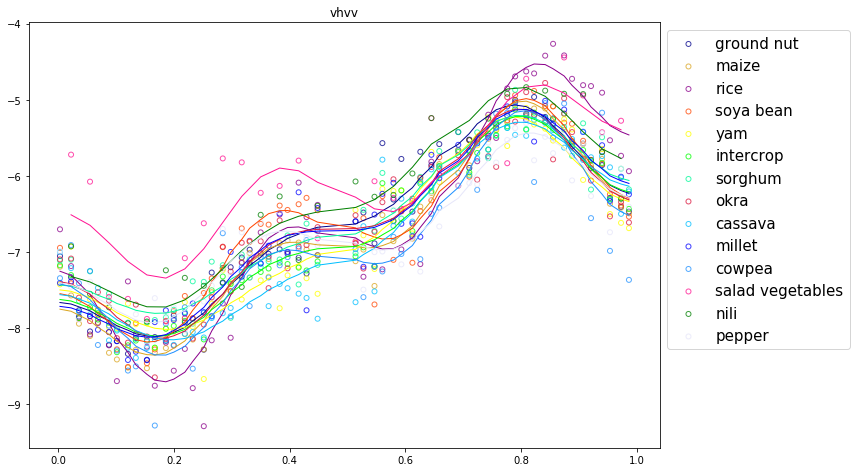

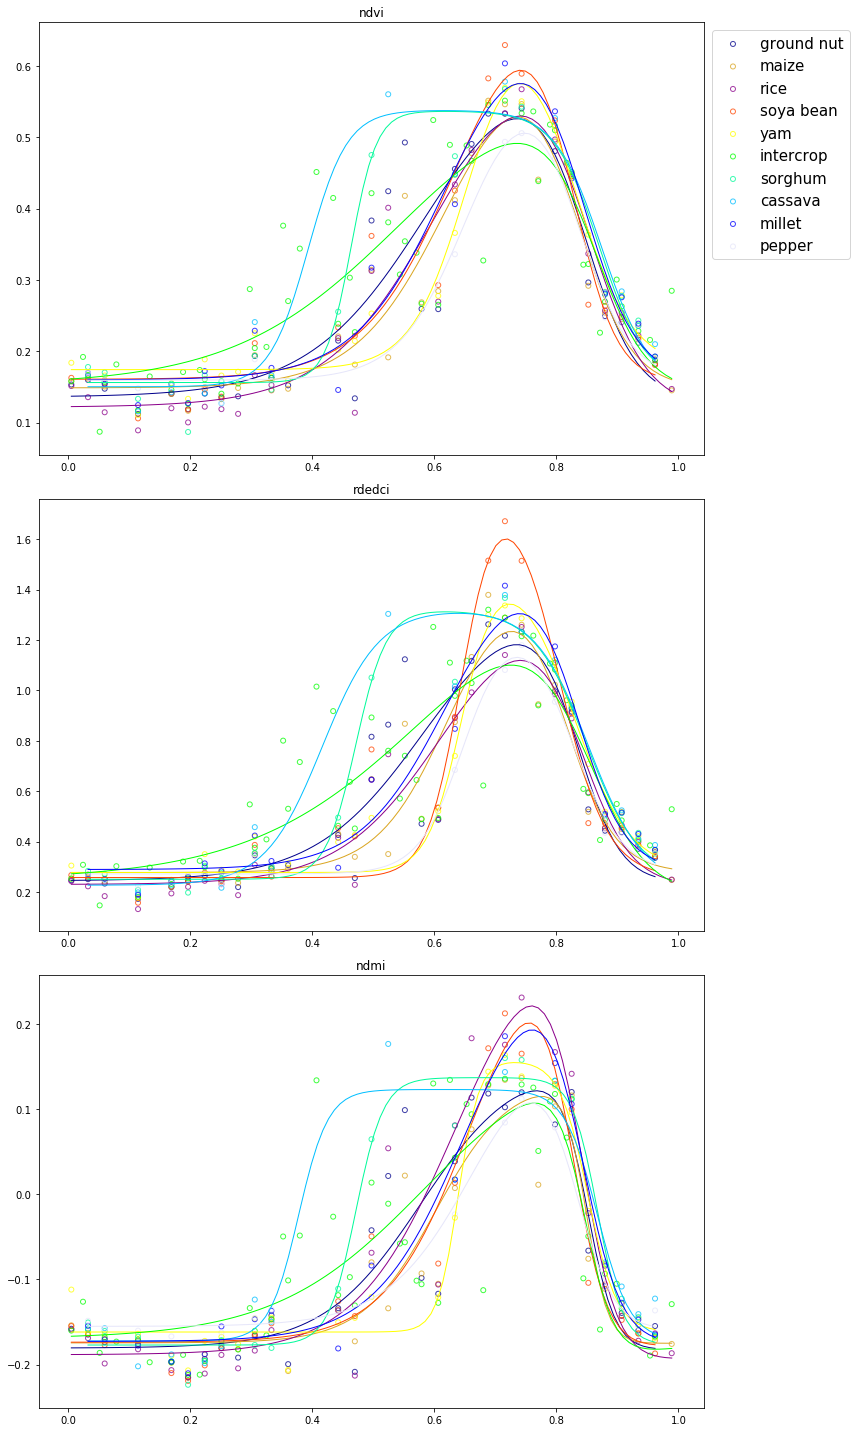

In [4]:
#####
ndctcoeff = 6
ndlcoeff = 6
percentile = 50
#####

import matplotlib.pyplot
import scipy.interpolate

from compression import dct
from compression import idct
from compression import doublelogistic
from compression import dbllogifunc
from miscellaneous import fusedataandweight

fig,ax = matplotlib.pyplot.subplots(figsize=[12,20/3])
for i in range(len(s1vi)):
    for j in range(len(s1vi[i])):
        x = []
        y = []
        for k in range(len(s1vi[i][j])):
            if len(s1vi[i][j][k]) > 500:
                x.append(k/diy)
                y.append(numpy.nanpercentile(s1vi[i][j][k],percentile))    
        if len(x) > 15:
            ax.scatter(x,y,edgecolors=groundlabels[i]["colour"],facecolors="None",s=25,alpha=0.75,label=groundlabels[i]["crop"])
            dctcoeff = dct(y,len(y))
            inverse = idct(dctcoeff,ndctcoeff)    
            ax.plot(x,inverse,color=groundlabels[i]["colour"],alpha=1,lw=1)
            ax.set_title(f"{s1indices[j]}")
ax.legend(bbox_to_anchor=(1.0,1.0),loc="upper left",fontsize=15)
matplotlib.pyplot.tight_layout()
matplotlib.pyplot.show()

fig,ax = matplotlib.pyplot.subplots(3,1,figsize=[12,20])
axs = ax.ravel()
for i in range(len(s2vi)):
    for j in range(len(s2vi[i])):
        x = []
        y = []
        for k in range(len(s2vi[i][j])):
            if len(s2vi[i][j][k]) > 500:
                x.append(k/diy)
                y.append(numpy.percentile(s2vi[i][j][k],percentile))    
        if len(x) > 15:
            axs[j].scatter(x,y,edgecolors=groundlabels[i]["colour"],facecolors="None",s=25,alpha=0.75,label=groundlabels[i]["crop"])
            spline = scipy.interpolate.UnivariateSpline(x,y,s=0.01,k=3)
            xnew = numpy.linspace(numpy.min(x),numpy.max(x),100)
            xf,yf,weights = fusedataandweight(x,y,xnew,spline(xnew),weight=[0.1,1.0])
            dbllog = doublelogistic(xf,yf,weights=weights,bound=True,epsilon=0.1)
            axs[j].plot(xnew,dbllogifunc(xnew,*dbllog),color=groundlabels[i]["colour"],alpha=1,lw=1)
            axs[j].set_title(f"{s2indices[j]}")
axs[0].legend(bbox_to_anchor=(1.0,1.0),loc="upper left",fontsize=15)
matplotlib.pyplot.tight_layout()
matplotlib.pyplot.show()

In [5]:
#####
percentiles = [50,55,60]
#####

coeff = numpy.zeros((len(groundlabels)*len(percentiles),len(s1indices)*ndctcoeff+len(s2indices)*ndlcoeff+1))
index = 0
for i in range(len(s1vi)):
    for j in range(len(percentiles)):
        for k in range(len(s1vi[i])):
            x = []
            y = []
            for m in range(len(s1vi[i][k])):
                if len(s1vi[i][k][m]) > 500:
                    x.append(m/diy)
                    y.append(numpy.nanpercentile(s1vi[i][k][m],percentiles[j]))    
            if len(x) > 15:
                dctcoeff = dct(y,ndctcoeff)
                coeff[index,1:(1+ndctcoeff)] = dctcoeff
            coeff[index,0] = i
        index = index + 1

index = 0
for i in range(len(s2vi)):
    for j in range(len(percentiles)):
        for k in range(len(s2vi[i])):
            x = []
            y = []
            for m in range(len(s2vi[i][k])):
                if len(s2vi[i][k][m]) > 500:
                    x.append(m/diy)
                    y.append(numpy.nanpercentile(s2vi[i][k][m],percentiles[j]))    
            if len(x) > 15:
                spline = scipy.interpolate.UnivariateSpline(x,y,s=0.01,k=3)
                xnew = numpy.linspace(numpy.min(x),numpy.max(x),100)
                xf,yf,weights = fusedataandweight(x,y,xnew,spline(xnew),weight=[0.1,1.0])
                dbllog = doublelogistic(xf,yf,weights=weights,bound=True,epsilon=0.1)
                coeff[index,(1+ndctcoeff+ndlcoeff*k):(1+ndctcoeff+ndlcoeff+ndlcoeff*k)] = dbllog
        index = index + 1

coeff[coeff == 0] = numpy.nan
coeff = coeff[~numpy.isnan(coeff).any(axis=1)]

PC  stddev varprop
PC1 3.0057 0.3764
PC2 2.3493 0.2300
PC3 1.5170 0.0959
PC4 1.4152 0.0835
PC5 1.2347 0.0635
PC6 1.0766 0.0483
PC7 1.0180 0.0432
PC8 0.7758 0.0251
PC9 0.6235 0.0162
PC10 0.5233 0.0114
PC11 0.3085 0.0040
PC12 0.1604 0.0011
PC13 0.1115 0.0005
PC14 0.1014 0.0004
PC15 0.0771 0.0002
PC16 0.0594 0.0001
PC17 0.0440 0.0001
PC18 0.0387 0.0001
PC19 0.0305 0.0000
PC20 0.0201 0.0000
PC21 0.0144 0.0000
PC22 0.0136 0.0000
PC23 0.0080 0.0000
PC24 0.0021 0.0000


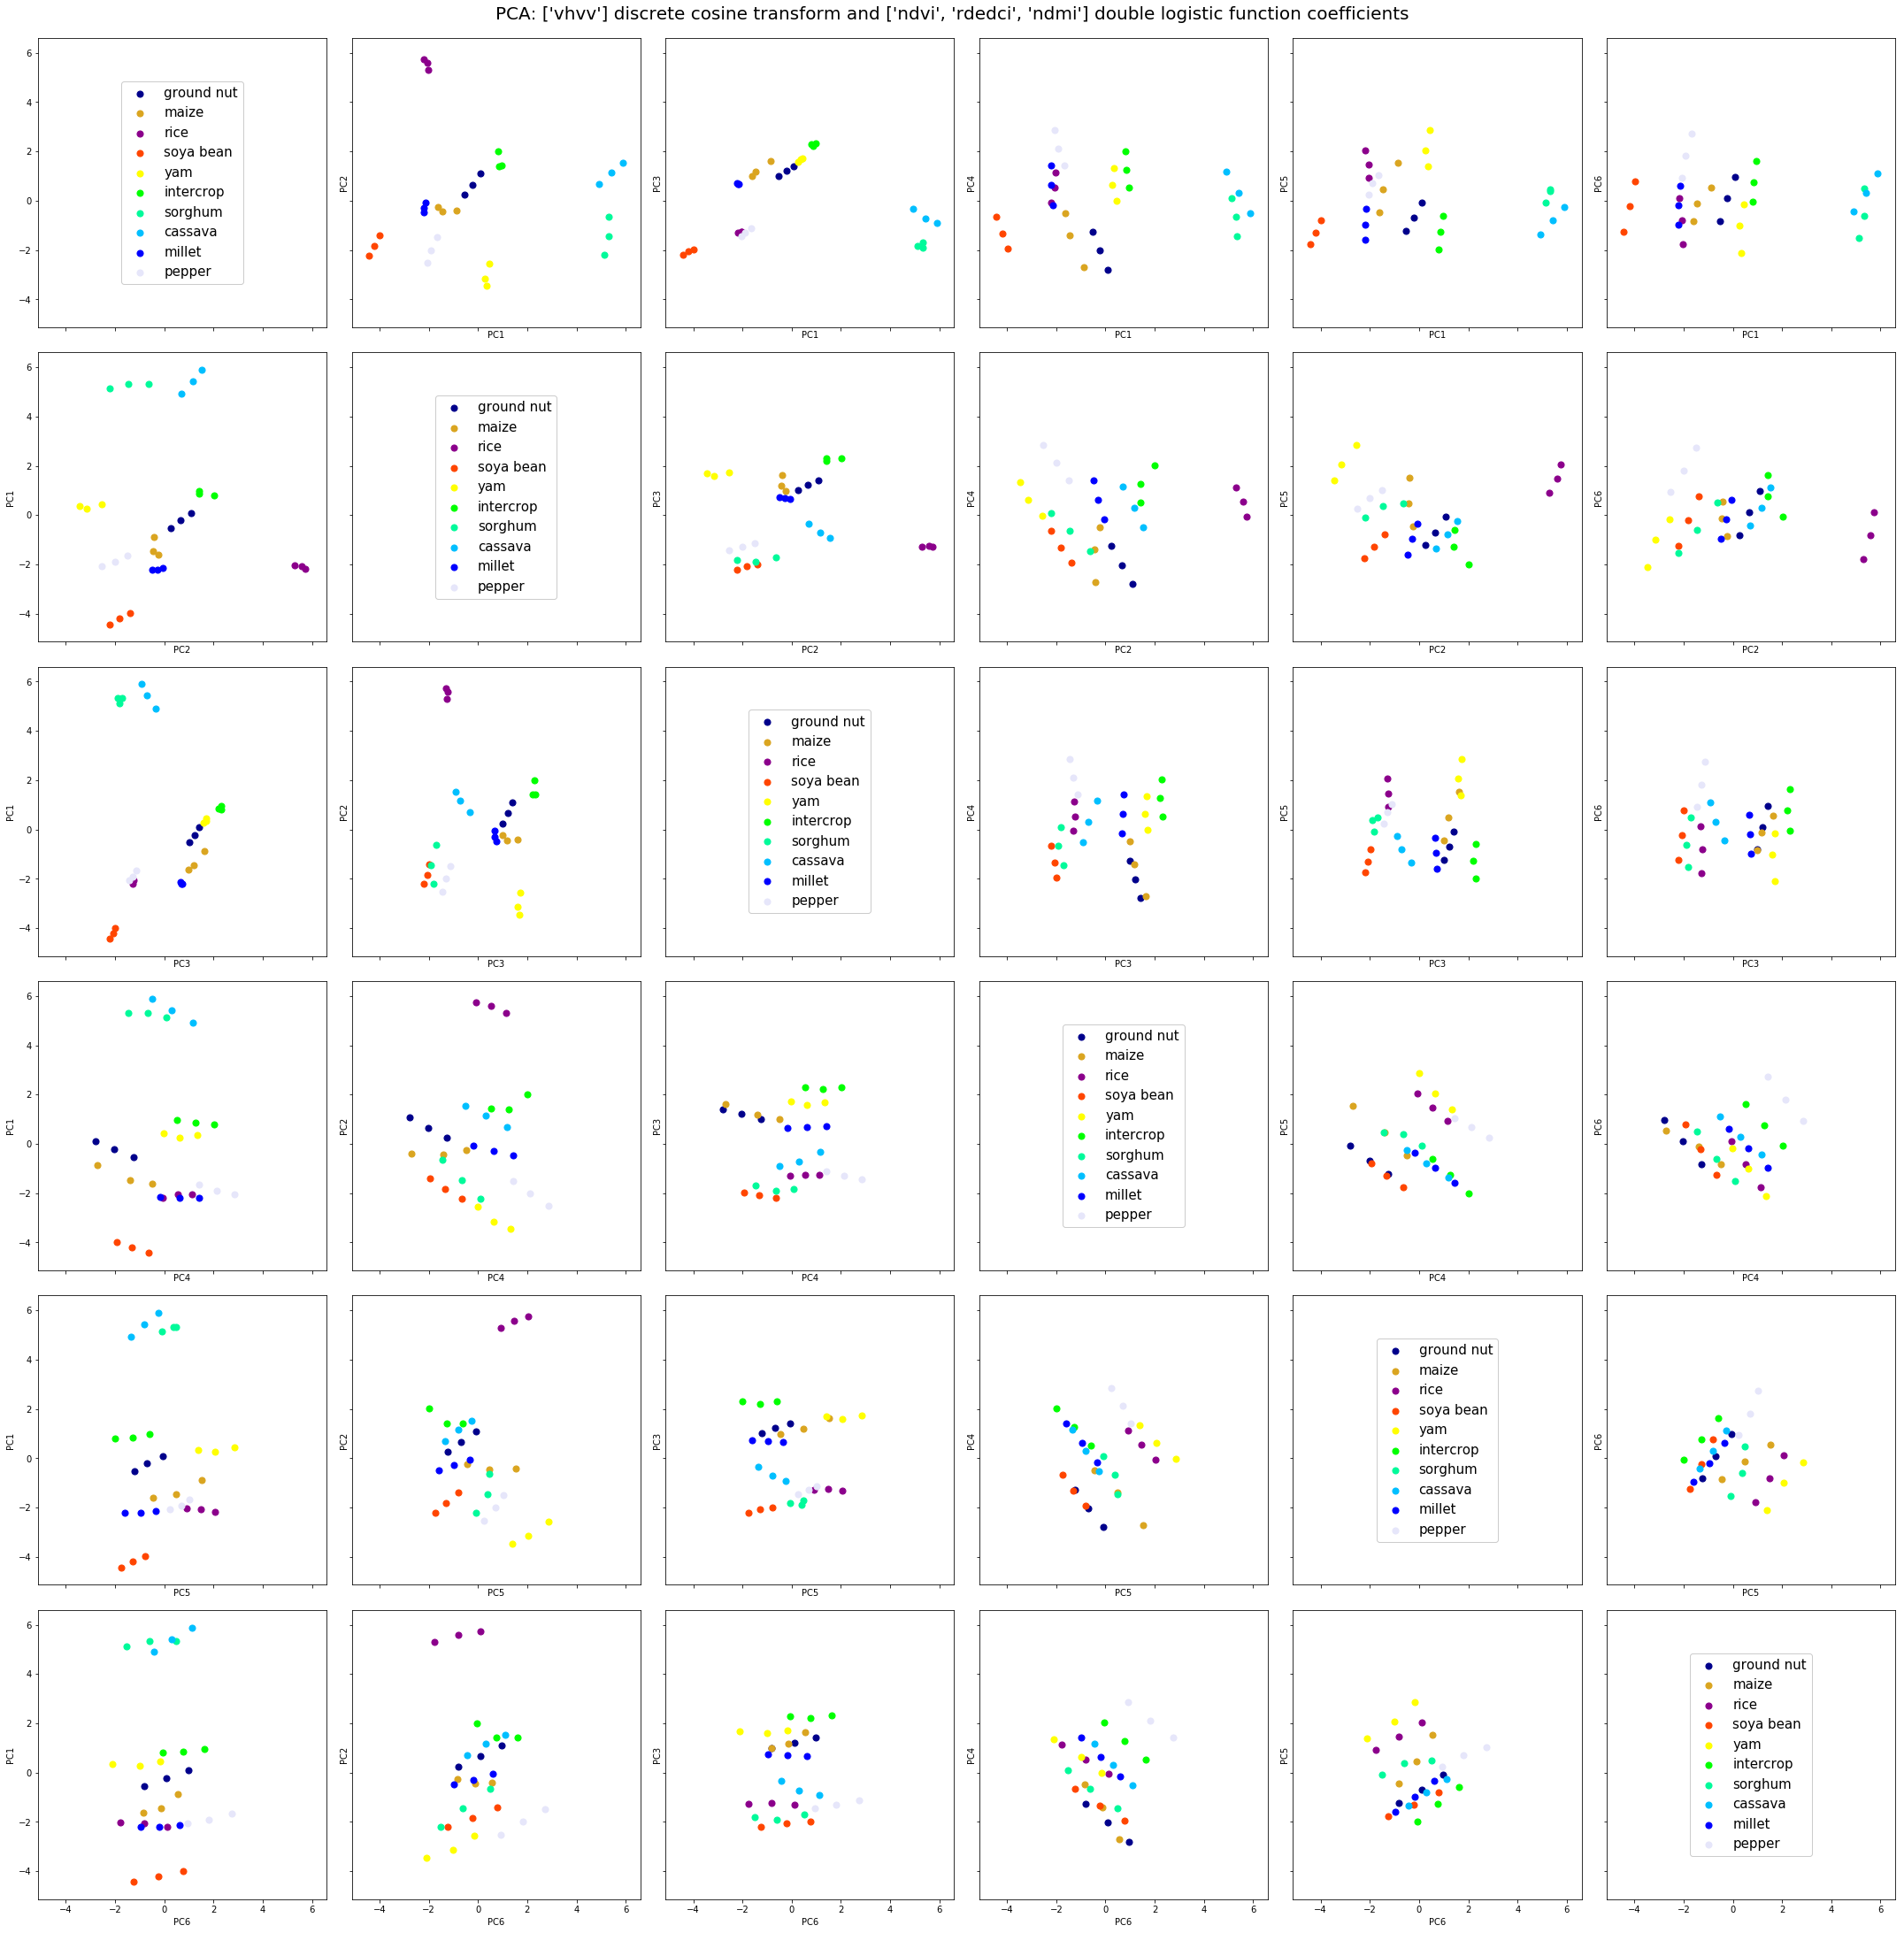

In [6]:
#####
npca = 6
#####

import sklearn.preprocessing
import sklearn.decomposition

y = coeff[:,0]
X = coeff[:,1:]
X = sklearn.preprocessing.scale(X)
pca = sklearn.decomposition.PCA().fit(X)
X_pca = pca.transform(X)
varprop = pca.explained_variance_ratio_
stddev = numpy.std(X_pca,axis=0)
print("PC"," stddev", "varprop")
for i in range(len(varprop)):
    print(f"PC{i+1}","{:.4f}".format(stddev[i]),"{:.4f}".format(varprop[i]))
    
crops = numpy.unique(numpy.array(y,dtype="int"))
fig,ax = matplotlib.pyplot.subplots(npca,npca,figsize=[30,30],sharex="all",sharey="all")
axs = ax.ravel()
idx = 0
for i in range(npca):
    for j in range(npca):
        if i == j:
            for k in range(len(crops)):
                axs[idx].scatter(0,0,color=groundlabels[crops[k]]["colour"],s=50,alpha=1,label=f'{groundlabels[crops[k]]["crop"]}',zorder=-10)
            axs[idx].legend(loc="center",fontsize=15,framealpha=1)
        if i != j:
            axs[idx].set_xlabel(f"PC{i+1}")
            axs[idx].set_ylabel(f"PC{j+1}")
            for k in range(len(crops)):
                axs[idx].scatter(X_pca[:,i][y==crops[k]],X_pca[:,j][y==crops[k]],color=groundlabels[crops[k]]["colour"],s=50,alpha=1)
        idx = idx + 1
matplotlib.pyplot.suptitle(f'PCA: {s1indices} discrete cosine transform and {s2indices} double logistic function coefficients',y=1.01,fontsize=20)
matplotlib.pyplot.tight_layout()
matplotlib.pyplot.show()